## News Scraper Implementation (scraping.py)

This script defines a class-based structure for scraping news article content from a list of URLs. It uses the `requests` library for fetching HTML and the `trafilatura` library for robust content extraction. Key features include configuration management, retry logic, rate limiting, logging, and checkpointing for resuming interrupted jobs.

### 1. Configuration (ScraperConfig)

- **Defines constants** for the scraping process, including:
  - `CHUNK_SIZE`/`checkpoint_interval`: How often to save progress (default 100).
  - `MIN_DELAY` and `MAX_DELAY`: Defines a random time delay (rate limiting) between requests (2.0 to 5.0 seconds).
  - `TIMEOUT`: Request timeout (15 seconds).
  - `MAX_RETRIES`: Number of times to retry a failed request (3).
  - `MIN_ARTICLE_LENGTH`: Minimum characters required for extracted text to be considered a valid article (200).
  - `USER_AGENTS`: A list of different user agents to rotate, helping to avoid bot detection.
  - `SKIP_PATTERNS`: A list of URL patterns (e.g., '/video/', '/foto/') that indicate non-article pages which should be skipped immediately.

### 2. Setup (Logging)

- Sets up standard logging to both the console and a file named `scraper.log` to track activity, warnings, and errors.

### 3. NewsScraper Class

The main class that encapsulates the scraping logic.

#### Key Methods

- **`__init__`**: Initializes the class, creates a persistent `requests.Session`, and initializes a `stats` dictionary to track success, failure, and skips, broken down by source domain.
- **`should_skip_url(self, url)`**: Checks if a URL contains any of the defined `SKIP_PATTERNS`.
- **`get_domain(self, url)`**: Extracts the clean domain name (netloc) from the URL.
- **`fetch_with_retry(self, url)`**:
  - Implements the core fetching mechanism.
  - Randomly selects a `User-Agent` for each request.
  - Uses a loop to retry the request up to `MAX_RETRIES` times upon `Timeout` or other `RequestException` errors.
  - Uses exponential backoff (`time.sleep(2 ** attempt)`) before retrying.
  - Raises an exception for bad HTTP status codes (`response.raise_for_status()`).
- **`extract_article(self, html, url)`**:
  - Uses `trafilatura.extract` to intelligently pull the main article text from the HTML content.
  - Gathers article metadata (title, author, date, description) using `trafilatura.extract_metadata`.
  - Returns `None` if the extraction fails or the content is shorter than `MIN_ARTICLE_LENGTH`.
- **`scrape_url(self, url)`**:
  - The single-URL processing pipeline.
  - Checks for skip patterns.
  - Calls `fetch_with_retry` and then `extract_article`.
  - Records the outcome (`success`, `failed`, or `skipped`) in the result dictionary and updates the internal `self.stats`.
- **`save_checkpoint(self, results, checkpoint_file)`**: Saves all collected results into a temporary CSV file (`_checkpoint.csv`) to protect progress.
- **`load_checkpoint(self, checkpoint_file)`**: Loads existing results and a set of already processed URLs from the checkpoint file, enabling the scraping job to **resume** where it left off.
- **`scrape_dataset(...)`**:
  - The main control function.
  - Loads existing progress via `load_checkpoint`.
  - Filters the input URLs to process only those not yet completed.
  - Iterates through the remaining URLs, calling `scrape_url`.
  - Applies a **random delay** between requests for rate limiting.
  - Saves a checkpoint every `checkpoint_interval` (default 50 in the main block).
  - After completion, saves the final results to the specified `output_file` and removes the checkpoint file.

### 4. Main Execution Block (`if __name__ == "__main__":`)

- **Loads Data:** Reads the list of URLs from a source CSV file (`fidelity_check_model/data/NewsDataClean_fidelity.csv`) into a pandas DataFrame.
- **Initializes:** Creates instances of `ScraperConfig` and `NewsScraper`.
- **Runs Scraper:** Calls `scraper.scrape_dataset` with the loaded DataFrame and sets the checkpoint interval to 50.
- **Analysis:** Prints final statistics, showing the count of `success`, `failed`, and `skipped` articles, and breaks down the status counts by **domain**.


# Scraping Results

## EDA

In [41]:
import pandas as pd
df = pd.read_csv('scraped_articles.csv')
df.head()

,url,status,domain,scraped_at,text,title,author,date,description,error
0,https://www.antaranews.com/berita/5182401/teru...,success,antaranews.com,2025-11-28T00:41:19.747271,Jakarta (ANTARA) - Harga emas yang dikutip dar...,"Terus meroket, emas di Pegadaian ada yang sent...",Antaranews Com; Ahmad Muzdaffar Fauzan,2025-10-18,Harga emas yang dikutip dari laman resmi Sahab...,NaN
1,https://www.antaranews.com/berita/5135121/harg...,success,antaranews.com,2025-11-28T00:41:23.310704,Jakarta (ANTARA) - Harga emas yang dikutip dar...,Harga tiga produk emas di Pegadaian Jumat ini ...,Antaranews Com; Ahmad Muzdaffar Fauzan,2025-09-26,Harga emas yang dikutip dari laman resmi Sahab...,NaN
2,https://www.antaranews.com/berita/5014569/harg...,success,antaranews.com,2025-11-28T00:41:26.646167,Emas Galeri24 turun Rp2.000 dari angka Rp1.932...,"Harga terbaru emas Pegadaian, Galeri24-Antam t...",Antaranews Com; Ahmad Muzdaffar Fauzan,2025-08-05,Harga emas yang dikutip dari laman resmi Sahab...,NaN
3,https://www.antaranews.com/berita/4857989/harg...,success,antaranews.com,2025-11-28T00:41:28.814543,Jakarta (ANTARA) - Harga emas yang dikutip dar...,Harga emas di Pegadaian pada 26 Mei kompak stabil,Antaranews Com; Ahmad Muzdaffar Fauzan,2025-05-26,Harga emas yang dikutip dari laman resmi Pegad...,NaN
4,https://www.antaranews.com/berita/5123476/harg...,success,antaranews.com,2025-11-28T00:41:32.956931,Jakarta (ANTARA) - Harga emas yang dikutip dar...,"Harga emas Antam, Galeri24, UBS di Pegadaian h...",Antaranews Com; Ahmad Muzdaffar Fauzan,2025-09-21,Harga emas yang dikutip dari laman resmi Sahab...,NaN


In [42]:
df.shape

(1911, 10)

In [43]:
df.columns.tolist()

['url',
 'status',
 'domain',
 'scraped_at',
 'text',
 'title',
 'author',
 'date',
 'description',
 'error']

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911 entries, 0 to 1910
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   url          1911 non-null   object
 1   status       1911 non-null   object
 2   domain       1911 non-null   object
 3   scraped_at   1911 non-null   object
 4   text         1908 non-null   object
 5   title        1908 non-null   object
 6   author       1902 non-null   object
 7   date         1908 non-null   object
 8   description  1908 non-null   object
 9   error        3 non-null      object
dtypes: object(10)
memory usage: 149.4+ KB


Explanation:
- text = the cleaned main article body that trafilatura extracts from the page content
- description = a short blurb from HTML metadata(typically from og: description, twitter:description, or meta name = description). IT IS NOT THE BODY. It ofter overlaps with the first sentence of the article and can be missing or generic per site.
-  title/author/date come from metadata too. Come from trafilatura.extract_metadata that i used in scraping.py
- We decided to keep the text as ground truth for NLP.
- & Also to keep description only as a candidate summary. WHY? because it can be redundant. Usually, many sites reuse the first paragraph as description. Some evenn put marketing copy instead.

In [45]:
df['status'].value_counts()

,count
status,
success,1908
failed,3


In [46]:
df['error'].value_counts()

,count
error,
failed to fetch,3


Since all 3 of the failed scraping doesnt have any value, we just drop it

In [47]:
df = df[df['status'] == 'success'].copy()

In [48]:
df['status'].value_counts()

,count
status,
success,1908


In [49]:
df['error'].value_counts()

,count
error,


In [50]:
df['domain'].value_counts()

,count
domain,
antaranews.com,784
economy.okezone.com,353
ekonomi.republika.co.id,247
pusatdata.kontan.co.id,119
investasi.kontan.co.id,85
merdeka.com,68
jogja.antaranews.com,50
news.republika.co.id,31
insight.kontan.co.id,29


It comes from 5 main sources:

1. antaranews.com
2. republika.co.id
3. kontan.co.id
4. okezone.com
5. merdeka.com

### Raw Samples

In [51]:
#raw samples
for i, s in enumerate(df['text'].dropna().head(10).astype(str)):
    print(f'---- SAMPLE {i} ----')
    print(s[:800]) #show first 800 words
    print()

---- SAMPLE 0 ----
Jakarta (ANTARA) - Harga emas yang dikutip dari laman resmi Sahabat Pegadaian, Sabtu (18/10), menunjukkan tiga produk logam mulia yakni buatan UBS, Galeri24, dan Antam, yang kompak mengalami kenaikan harga empat hari beruntun.
Harga jual emas Antam meroket lagi ke angka Rp2.734.000 dari awalnya Rp2.648.000 per gram, begitu pula emas Galeri24 turut naik dari semula Rp2.426.000 menjadi Rp2.512.000 per gram.
Sama seperti Antam dan Galeri24, UBS juga mengalami kenaikan ke angka Rp2.545.000 dari awalnya dibandrol dengan harga Rp2.471.000 per gram.
Emas Galeri24 dijual dengan kuantitas 0,5 gram hingga 1.000 gram atau 1 kilogram. Sementara emas UBS dijual dengan kuantitas 0,5 gram hingga 500 gram.Berikut daftar lengkap harga emas masing-masing produk:
Baca juga: Harga emas Antam hari ini naik lag

---- SAMPLE 1 ----
Jakarta (ANTARA) - Harga emas yang dikutip dari laman resmi Sahabat Pegadaian, Jumat, menunjukkan harga tiga produk logam mulia, yakni buatan UBS, Galeri24, dan

### Character and Words in Article

In [52]:
char_len = df['text'].astype(str).map(len)
word_len = df['text'].astype(str).map(lambda s: len(s.split()))

pd.DataFrame({
    'char_len': char_len,
    'word_len': word_len
}).describe()

,char_len,word_len
count,1908.000000,1908.000000
mean,2081.907233,307.458595
std,1082.966494,150.232914
min,299.000000,46.000000
25%,1482.750000,230.750000
50%,1892.000000,287.000000
75%,2565.000000,383.000000
max,14032.000000,1939.000000


Majority of the articles have around 1.8k to 2.5k characters (≈230-380 words). But, there is a big variety, indicated by the shortest article that has only 46 words and the longest article containing almost 2000 words.

### Article Word Distribution

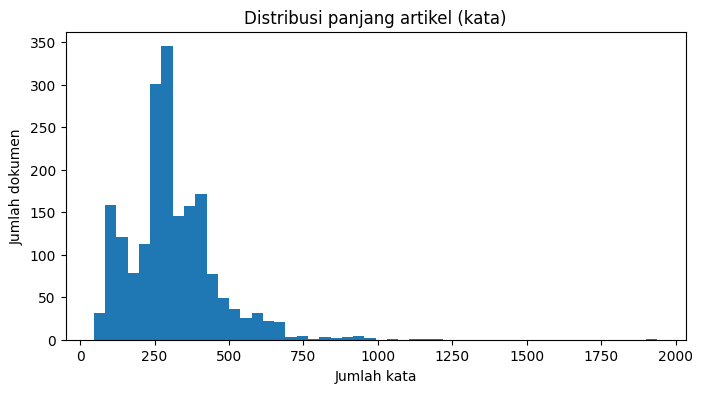

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(word_len.dropna(), bins=50)
plt.title('Distribusi panjang artikel (kata)')
plt.xlabel('Jumlah kata')
plt.ylabel('Jumlah dokumen')
plt.show()

This shows that most of the news articles are on the range of 200-450 words. But, there are some articles that have 1000 words or more

### Top 30 words

In [54]:
from collections import Counter
all_words = " ".join(df['text'].dropna().astype(str)).lower().split()
cnt = Counter(all_words)
cnt.most_common(30)

[('emas', 27124),
 ('harga', 25884),
 ('-', 13888),
 ('gram:', 13885),
 ('di', 9134),
 ('dan', 8342),
 ('yang', 7951),
 ('antam', 7404),
 ('dari', 6210),
 ('untuk', 5841),
 ('dengan', 5832),
 ('ini', 5641),
 ('per', 5458),
 ('rp', 5362),
 ('galeri24', 3402),
 ('pada', 3292),
 ('ubs', 3144),
 ('pangan', 2941),
 ('batangan', 2879),
 ('gram', 2777),
 ('beras', 2768),
 ('hari', 2671),
 ('menjadi', 2481),
 ('dalam', 2443),
 ('persen', 2380),
 ('logam', 2300),
 ('baca', 2266),
 ('juga:', 2244),
 ('gram.', 2173),
 ('juga', 2095)]

We can see that a majority of the articles have the word *'emas'* and *'harga'*, which means most of the articles are talking about the price of gold over time

## Preprocessing

In [55]:
cols_to_drop = ['status', 'scraped_at', 'author', 'description', 'error']

df = df.drop(columns=cols_to_drop, errors='ignore')
df.head()

,url,domain,text,title,date
0,https://www.antaranews.com/berita/5182401/teru...,antaranews.com,Jakarta (ANTARA) - Harga emas yang dikutip dar...,"Terus meroket, emas di Pegadaian ada yang sent...",2025-10-18
1,https://www.antaranews.com/berita/5135121/harg...,antaranews.com,Jakarta (ANTARA) - Harga emas yang dikutip dar...,Harga tiga produk emas di Pegadaian Jumat ini ...,2025-09-26
2,https://www.antaranews.com/berita/5014569/harg...,antaranews.com,Emas Galeri24 turun Rp2.000 dari angka Rp1.932...,"Harga terbaru emas Pegadaian, Galeri24-Antam t...",2025-08-05
3,https://www.antaranews.com/berita/4857989/harg...,antaranews.com,Jakarta (ANTARA) - Harga emas yang dikutip dar...,Harga emas di Pegadaian pada 26 Mei kompak stabil,2025-05-26
4,https://www.antaranews.com/berita/5123476/harg...,antaranews.com,Jakarta (ANTARA) - Harga emas yang dikutip dar...,"Harga emas Antam, Galeri24, UBS di Pegadaian h...",2025-09-21


### Normalize Text

In [56]:
import unicodedata
import re

def normalize_text(s):
    s = s.strip()
    # normalize unicode to NFKC
    s = unicodedata.normalize('NFKC', s)
    s = re.sub(r"[–—−]", "-", s)
    s = re.sub(r"--", "-", s)
    # collapse whitespace
    s = re.sub(r'\s+', ' ', s)
    # lower
    s = s.lower()
    return s

In [57]:
df['text'] = df['text'].map(normalize_text)
df['text'].head()

,text
0,jakarta (antara) - harga emas yang dikutip dar...
1,jakarta (antara) - harga emas yang dikutip dar...
2,emas galeri24 turun rp2.000 dari angka rp1.932...
3,jakarta (antara) - harga emas yang dikutip dar...
4,jakarta (antara) - harga emas yang dikutip dar...


### Separate per Domain

In [58]:
df_antara = df[df['domain'].str.contains('antaranews.com', case=False, na=False)].copy()
df_kontan = df[df['domain'].str.contains('kontan.co.id', case = False, na = False)].copy()
df_republika = df[df['domain'].str.contains('republika.co.id',case=False, na=False)].copy()
df_okezone = df[df['domain'].str.contains('okezone.com',case=False,na=False)].copy()
df_merdeka = df[df['domain'].str.contains('merdeka.com',case=False,na=False)].copy()

In [59]:
print(len(df_antara), len(df_kontan), len(df_republika), len(df_okezone), len(df_merdeka))
print(len(df_antara) + len(df_kontan) + len(df_republika) + len(df_okezone) + len(df_merdeka))

880 293 302 365 68
1908


### Remove Boilerplate per Domain

#### Antara

In [60]:
boiler_antara = [
    # === Antara ===
    r'^\s*[A-Za-zÀ-ž\s\.,-]+\(ANTARA\)\s*-\s*', # dateline
    r'\bBaca\s*juga\s?:.*',                     # related links
    r'Pewarta\s?:\s?.*',                        # reporter credit
    r'Editor\s?:\s?.*',                         # editor credit
    r'Copyright\s.*',                           # copyright/footer
    r'Copyright\s*Â©',                          # weird encoding
    r'\s*Berikut daftar lengkap harga emas.*',  # connector phrase,
]

In [61]:
def clean_antara(text, patterns=boiler_antara):
    if not isinstance(text, str):
        return text
    out = text
    for p in patterns:
        try:
            out = re.sub(p, ' ', out, flags=re.IGNORECASE | re.MULTILINE)
        except re.error:
            # skip bad pattern
            continue
    # collapse whitespace/newlines
    out = re.sub(r'\s+', ' ', out).strip()
    return out

df_antara['clean_text'] = df_antara['text'].map(clean_antara)

In [62]:
df_antara.head(50)

,url,domain,text,title,date,clean_text
0,https://www.antaranews.com/berita/5182401/teru...,antaranews.com,jakarta (antara) - harga emas yang dikutip dar...,"Terus meroket, emas di Pegadaian ada yang sent...",2025-10-18,harga emas yang dikutip dari laman resmi sahab...
1,https://www.antaranews.com/berita/5135121/harg...,antaranews.com,jakarta (antara) - harga emas yang dikutip dar...,Harga tiga produk emas di Pegadaian Jumat ini ...,2025-09-26,harga emas yang dikutip dari laman resmi sahab...
2,https://www.antaranews.com/berita/5014569/harg...,antaranews.com,emas galeri24 turun rp2.000 dari angka rp1.932...,"Harga terbaru emas Pegadaian, Galeri24-Antam t...",2025-08-05,emas galeri24 turun rp2.000 dari angka rp1.932...
3,https://www.antaranews.com/berita/4857989/harg...,antaranews.com,jakarta (antara) - harga emas yang dikutip dar...,Harga emas di Pegadaian pada 26 Mei kompak stabil,2025-05-26,harga emas yang dikutip dari laman resmi pegad...
4,https://www.antaranews.com/berita/5123476/harg...,antaranews.com,jakarta (antara) - harga emas yang dikutip dar...,"Harga emas Antam, Galeri24, UBS di Pegadaian h...",2025-09-21,harga emas yang dikutip dari laman resmi sahab...
5,https://www.antaranews.com/berita/5050213/harg...,antaranews.com,jakarta (antara) - harga emas antam yang dipan...,Harga emas Antam hari ini turun Rp7.000 menjad...,2025-08-20,harga emas antam yang dipantau dari laman loga...
6,https://www.antaranews.com/berita/4776201/kapa...,antaranews.com,jakarta (antara) - dalam beberapa waktu terakh...,Kapan waktu terbaik untuk membeli emas? Ini ja...,2025-04-17,"dalam beberapa waktu terakhir, harga emas di p..."
7,https://www.antaranews.com/berita/5205597/emas...,antaranews.com,"manado, sulawesi utara (antara) - harga emas y...",Emas di Pegadaian hari ini lanjutkan tren penu...,2025-10-29,harga emas yang dikutip dari laman resmi sahab...
8,https://www.antaranews.com/berita/4730509/harg...,antaranews.com,jakarta (antara) - harga emas yang dikutip dar...,"Harga emas Antam, UBS, dan Galeri24 di Pegadai...",2025-03-23,harga emas yang dikutip dari laman resmi pegad...
9,https://www.antaranews.com/berita/5047473/harg...,antaranews.com,jakarta (antara) - harga emas yang dikutip dar...,Harga emas UBS-Galeri24-Antam di Pegadaian har...,2025-08-19,harga emas yang dikutip dari laman resmi sahab...


#### Kontan

In [63]:
boiler_kontan = [
    # full-line boilerplate (drop whole line)
    r'^\s*Baca\s+Juga\s*:.*$',
    r'^\s*Tonton\s*:.*$',
    r'^\s*Selengkapnya\s*:.*$',
    r'^\s*Cek\s+Berita\s+dan\s+Artikel\s+yang\s+lain\s+di\s+Google\s+News\b.*$',
    r'^\s*Grafik\s+Harga\s+.*$',

    # leftover inline patterns to remove (non-greedy)
    r'\bBaca\s+Juga[:\s].*',
]

In [64]:
def clean_kontan(text, patterns=boiler_kontan):
    if not isinstance(text, str):
        return text

    # normalize common mojibake / smart quotes
    s = text.replace('â€œ', '"').replace('â€\x9d', '"').replace('\u201c','"').replace('\u201d','"')
    s = s.replace('\u2018', "'").replace('\u2019', "'")

    # special handling
    out_lines = []
    for ln in s.splitlines():
        ln = ln.rstrip()
        if not ln.strip():
            continue

        # 1) remove byline block before site token
        ln = re.sub(
            r'^(?:\s*(?:Reporter|Penulis|Editor|By)\s*[:\-]\s*[^|]+(?:\|\s*)?)+(?=\s*(?:\w+\.)*\w+\.co\.id)',
            '',
            ln,
            flags=re.IGNORECASE
        )

        # 2) remove a leading single label (Reporter:/Penulis:/Editor:/By:) but keep rest
        ln = re.sub(
            r'^\s*(?:Reporter|Penulis|Editor|By)\s*[:\-]\s*',
            '',
            ln,
            flags=re.IGNORECASE,
            count=1
        )

        # 3) remove leading site token like 'pusatdata.kontan.co.id' or 'kontan.co.id -'
        ln = re.sub(
            r'^\s*(?:\w+\.)*?kontan(?:\.co\.id)?[\s,:-–—]*',
            '',
            ln,
            flags=re.IGNORECASE,
            count=1
        )

        # 4) remove grahanusa publisher token if present
        ln = re.sub(
            r'^\s*Grahanusa\s+Mediatama\s*[-–—]+\s*',
            '',
            ln,
            flags=re.IGNORECASE,
            count=1
        )

        # 5) remove dateline prefix like 'Jakarta -' but preserve the remainder of the line
        ln = re.sub(
            r'^\s*[A-Za-zÀ-ž0-9\.\s]{1,60}?'
            r'(?:,\s*[A-Za-zÀ-ž\.\s]{1,40})?'
            r'(?:,\s*)?[-–—]{1,2}\s*''',
            '',
            ln,
            flags=re.IGNORECASE,
            count=1
        )

        # 6) strip leftover leading punctuation/spaces and inline 'Baca Juga' leftovers
        ln = re.sub(
            r'^\s*[-–—\|:,.\s]+',
            '',
            ln
        )

        ln = re.sub(
            r'\bBaca\s+Juga[:\s].*',
            ' ',
            ln,
            flags=re.IGNORECASE
        )

        # normalize intermediate whitespace
        ln = re.sub(r'\s+', ' ', ln).strip()
        if not ln:
            continue

        out_lines.append(ln)

    # re-join lines into a working text for pattern loop
    working = '\n'.join(out_lines)

    # apply boilerplate patterns via re.sub loop
    for p in patterns:
        try:
            # for line-anchored patterns we use MULTILINE to allow ^ matching each line
            working = re.sub(p, ' ', working, flags=re.IGNORECASE | re.MULTILINE)
        except re.error:
            # skip invalid pattern silently
            continue

    # collapse multiple whitespace/newlines to single space or paragraph breaks
    # keep paragraph structure: transform multiple newlines into two newlines first, then collapse spaces
    working = re.sub(r'\n{3,}', '\n\n', working)
    # normalize spaces but keep single newlines
    parts = [p.strip() for p in working.split('\n') if p.strip()]
    working = '\n'.join(parts)

    # final per-line duplicate-first-two handling (remove both if normalized-equal)
    final_lines = []
    for ln in working.splitlines():
        tokens = ln.split()
        # normalization helper
        def norm(tok):
            return re.sub(r'[^0-9A-Za-zÀ-ž]', '', tok).lower()

        # repeat removal until no duplicate-first-two remain
        while True:
            if len(tokens) >= 2 and norm(tokens[0]) and norm(tokens[0]) == norm(tokens[1]):
                # remove both tokens
                tokens = tokens[2:]
                continue
            # if first token ends with punctuation (rare now) remove it (keeps rest)
            if len(tokens) >= 1 and tokens[0].endswith(('.', ',')):
                tokens = tokens[1:]
                continue
            break

        ln2 = ' '.join(tokens).strip()
        if ln2:
            final_lines.append(ln2)

    out = '\n'.join(final_lines)
    out = re.sub(r'\n{3,}', '\n\n', out).strip()
    return out

df_kontan['clean_text'] = df_kontan['text'].map(clean_kontan)

In [65]:
df_kontan.head(50)

,url,domain,text,title,date,clean_text
44,https://pusatdata.kontan.co.id/news/grafik-har...,pusatdata.kontan.co.id,reporter: hasbi maulana | editor: hasbi maulan...,"Grafik Harga Emas Antam, Hari Ini Naik atau Tu...",2025-06-08,minggu (8 juni 2025) grafik harga emas 24 kara...
47,https://investasi.kontan.co.id/news/begini-car...,investasi.kontan.co.id,penulis: ryan suherlan kontan.co.id - harga em...,"Begini Cara Beli Emas Antam Logam Mulia, Harga...",2025-04-28,"harga emas antam hari ini senin, 28 april 2025..."
49,https://pusatdata.kontan.co.id/news/grafik-har...,pusatdata.kontan.co.id,reporter: hasbi maulana | editor: hasbi maulan...,"Grafik Harga Emas Antam, Hari Ini Naik atau Tu...",2025-03-28,"jumat (28 maret 2025), grafik harga emas 24 ka..."
271,https://pusatdata.kontan.co.id/news/grafik-har...,pusatdata.kontan.co.id,reporter: hasbi maulana | editor: hasbi maulan...,"Grafik Harga Emas Antam, Hari Ini Naik atau Tu...",2025-04-18,jumat (18 april 2025) grafik harga emas 24 kar...
273,https://pusatdata.kontan.co.id/news/grafik-har...,pusatdata.kontan.co.id,reporter: hasbi maulana | editor: hasbi maulan...,"Grafik Harga Emas Antam, Hari Ini Naik atau Tu...",2025-05-13,selasa (13 mei 2025) grafik harga emas 24 kara...
312,https://pusatdata.kontan.co.id/news/grafik-har...,pusatdata.kontan.co.id,reporter: hasbi maulana | editor: hasbi maulan...,"Grafik Harga Emas Antam, Hari Ini Naik atau Tu...",2025-05-09,jumat (9 mei 2025) grafik harga emas 24 karat ...
318,https://pusatdata.kontan.co.id/news/grafik-har...,pusatdata.kontan.co.id,reporter: hasbi maulana | editor: hasbi maulan...,"Grafik Harga Emas Antam, Hari Ini Naik atau Tu...",2025-07-27,minggu (27 juli 2025) hingga pukul 09.15 wib i...
322,https://insight.kontan.co.id/news/harga-emas-l...,insight.kontan.co.id,kontan.co.id - jakarta. harga emas logam mulia...,Harga Emas Logam Mulia Antam Bisa Menembus Rp ...,2025-09-06,harga emas logam mulia aneka tambang (antam) k...
881,https://insight.kontan.co.id/news/inflasi-diba...,insight.kontan.co.id,kontan.co.id-jakarta. jakarta. laju inflasi pa...,Inflasi Dibayangi Kenaikan Harga Non Pangan,2025-05-03,"laju inflasi pada bulan april 2025 melandai, n..."
884,https://pusatdata.kontan.co.id/news/grafik-har...,pusatdata.kontan.co.id,reporter: hasbi maulana | editor: hasbi maulan...,"Grafik Harga Emas Antam, Hari Ini Naik atau Tu...",2025-05-05,senin (5 mei 2025) grafik harga emas 24 karat ...


#### Republika

In [66]:
boiler_republika = [
    # Baca juga / promo
    r'^\s*Baca\s+juga\s*:.*$',
    r'^\s*Baca\s+juga:.*$',
    r'^\s*Baca\s+lagi\s*:.*$',
    r'^\s*Baca\s*:.*$',

    # credit / metadata
    r'^\s*Pewarta\s*:.*$',
    r'^\s*Editor\s*:.*$',
    r'^\s*Reporter\s*:.*$',

    # copyright / footer
    r'^\s*Copyright.*$',
    r'^\s*Dilarang\s+keras.*$',

    # footer lain
    r'^\s*Stok dan harga.*$',
    r'^\s*Related\s*:\s*.*$',
]

In [67]:
def clean_republika(text, patterns=boiler_republika):
    if not isinstance(text, str):
        return text

    lines = text.splitlines()
    keep = []
    for ln in lines:
        ln_strip = ln.strip()
        if ln_strip == '':
            continue

        ln_strip = re.sub(
            r'^\s*republika(?:\.co\.id)?\s*,\s*[A-Za-zÀ-ž\s\.]+\s*[-–—]{1,2}\s*',
            '',
            ln_strip,
            flags=re.IGNORECASE
        )
        ln_strip = re.sub(
            r'^\s*republika(?:\.co\.id)?\s*,\s*[A-Za-zÀ-ž\s\.]+(?:,\s*)?[-–—]{1,2}\s*',
            '',
            ln_strip,
            flags=re.IGNORECASE
        )
        ln_strip = re.sub(
            r'^\s*[A-Za-zÀ-ž\s\.,-]+\(ANTARA\)\s*-\s*',
            '',
            ln_strip,
            flags=re.IGNORECASE
        )
        drop = False
        for p in patterns[1:]:  # first pattern has already been handled
            if re.match(p, ln_strip, flags=re.IGNORECASE):
                drop = True
                break

        if not drop:
            keep.append(re.sub(r'\s+', ' ', ln_strip))

    out = '\n\n'.join(keep).strip()
    out = re.sub(r'(?<=[\.\?\!])\s+', '\n\n', out)
    return out

df_republika['clean_text'] = df_republika['text'].map(clean_republika)

In [68]:
df_republika.head(50)

,url,domain,text,title,date,clean_text
347,https://ekonomi.republika.co.id/berita/sswu1r4...,ekonomi.republika.co.id,"republika.co.id, semarang - wakil menteri pert...","Wamentan Sidak Pasar Johar, Temukan Harga Semb...",2025-03-10,wakil menteri pertanian (wamentan) sudaryono m...
1610,https://news.republika.co.id/berita/t2wru85530...,news.republika.co.id,"republika.co.id, jakarta, - harga emas mengala...","Harga Emas Antam, Galeri24, dan UBS di Pegadai...",2025-09-21,harga emas mengalami kenaikan signifikan pada ...
1611,https://news.republika.co.id/berita/t2wru88630...,news.republika.co.id,"republika.co.id, jakarta, - harga emas di pega...","Harga Emas Antam, Galeri24, dan UBS di Pegadai...",2025-09-21,harga emas di pegadaian mengalami lonjakan sig...
1612,https://ekonomi.republika.co.id/berita/t4k1wb4...,ekonomi.republika.co.id,"republika.co.id, jakarta - di bawah langit sor...","Mentan Amran Jemput Presiden Brasil, Setelah T...",2025-10-23,di bawah langit sore bandara halim perdanakusu...
1613,https://ekonomi.republika.co.id/berita/t6bavp3...,ekonomi.republika.co.id,"republika.co.id, jakarta - harga emas antam ya...","Daftar Lengkap Harga Emas Antam Hari Ini, Turu...",2025-11-26,harga emas antam yang dipantau dari laman loga...
1614,https://news.republika.co.id/berita/t4plv61300...,news.republika.co.id,"republika.co.id, jakarta, - harga emas di pega...",Harga Emas UBS dan Galeri24 Turun Tipis di Peg...,2025-10-26,harga emas di pegadaian menunjukkan tren penur...
1615,https://news.republika.co.id/berita/t0yeii7830...,news.republika.co.id,"republika.co.id, manado, - polda sulawesi utar...","Polda Sulut Distribusikan 63,85 Ton Beras dala...",2025-08-14,polda sulawesi utara (sulut) bekerja sama deng...
1616,https://republika.co.id/berita/ssfxeo456/bapan...,republika.co.id,"republika.co.id, jakarta - dalam upaya memasti...",Bapanas Gandeng Suri Nusantara Jaya Operasi Pa...,2025-03-01,dalam upaya memastikan dan menjaga harga panga...
1617,https://ekonomi.republika.co.id/berita/szq8hh4...,ekonomi.republika.co.id,"republika.co.id, jakarta - harga emas batangan...","Harga Emas Stabil Hari Ini, Cek Daftar Lengkap...",2025-07-21,harga emas batangan pt aneka tambang tbk (anta...
1618,https://ekonomi.republika.co.id/berita/t682ss3...,ekonomi.republika.co.id,"republika.co.id, jakarta - harga emas diperkir...","Harga Emas Dunia Turun 0,30 Persen, Ini Predik...",2025-11-24,harga emas diperkirakan bergerak fluktuatif se...


#### Okezone

In [69]:
boiler_okezone = [
    r'^\s*Baca\s+Juga[:\s].*$',
    r'^\s*Tonton[:\s].*$',
    r'^\s*Share[:\s].*$',
    r'^\s*Reporter\s*:.*$',
    r'^\s*Editor\s*:.*$',
    r'^\s*Penulis\s*:.*$',
    r'^\s*By\s+.*$',
    r'^\s*Copyright.*$',
    r'^\s*Disclaimer.*$',
    r'^\s*Dilarang\s+keras.*$',
    r'^\s*Follow\s+.*$',
    r'^\s*Ikuti\s+.*$',
    r'^\s*Cek\s+Berita.*Google\s*News.*$',
]

In [70]:
def clean_okezone(text, patterns=boiler_okezone):
    if not isinstance(text, str):
        return text

    # normalize some mojibake/smart quotes
    s = text.replace('â€œ', '"').replace('â€\x9d', '"').replace('\u201c', '"').replace('\u201d', '"')

    lines = s.splitlines()
    kept = []
    for ln in lines:
        ln_strip = ln.strip()
        if ln_strip == '':
            continue

        ln_strip = re.sub(
            r'^\s*(?:\w+\.)*?okezone(?:\.com)?[\s,:-–—]*',
            '',
            ln_strip,
            flags=re.IGNORECASE
        )
        ln_strip = re.sub(
            r'^\s*[A-Za-zÀ-ž0-9\.\s]{2,60}?(?:,\s*[A-Za-zÀ-ž\.\s]{2,40})?(?:,\s*)?[-–—]{1,2}\s*',
            '',
            ln_strip,
            flags=re.IGNORECASE
        )

        # drop line entirely if it matches boilerplate patterns
        drop = False
        for p in patterns:
            if re.match(p, ln_strip, flags=re.IGNORECASE):
                drop = True
                break
        if drop:
            continue

        # normalize internal whitespace and keep
        ln_clean = re.sub(r'\s+', ' ', ln_strip).strip()
        if ln_clean:
            kept.append(ln_clean)

    out = '\n\n'.join(kept)
    out = re.sub(r'\n{3,}', '\n\n', out).strip()
    return out

df_okezone['clean_text'] = df_okezone['text'].astype(str).map(clean_okezone)

In [71]:
df_okezone.head(50)

,url,domain,text,title,date,clean_text
53,https://economy.okezone.com/read/2025/03/31/32...,economy.okezone.com,"jakarta - kepala badan pusat statistik (bps), ...",BPS Soroti Harga Pangan hingga Penjualan Muken...,2025-03-31,"kepala badan pusat statistik (bps), amalia adi..."
266,https://economy.okezone.com/read/2025/11/22/32...,economy.okezone.com,jakarta - harga emas antam turun rp7.000 menja...,"Harga Emas Antam Turun Rp7.000, Kini Dijual Rp...",2025-11-22,harga emas antam turun rp7.000 menjadi rp2.341...
332,https://economy.okezone.com/read/2025/08/20/32...,economy.okezone.com,jakarta - ini rincian daya listrik yang dapat ...,Ini Rincian Daya Listrik yang Dapat Tarif Disk...,2025-08-20,ini rincian daya listrik yang dapat tarif disk...
338,https://economy.okezone.com/read/2025/04/17/11...,economy.okezone.com,jakarta - fenomena borong emas masih berlanjut...,"Borong Emas Kini Jadi Fenomena, Rasional atau ...",2025-04-17,fenomena borong emas masih berlanjut hingga sa...
340,https://economy.okezone.com/read/2025/01/09/32...,economy.okezone.com,jakarta - perum bulog memperkuat distribusi pa...,"Jaga Ketahanan Pangan, Bulog Perluas Distribus...",2025-01-09,perum bulog memperkuat distribusi pangan sampa...
341,https://economy.okezone.com/read/2025/02/19/32...,economy.okezone.com,jakarta - diskon tarif listrik 50% berlaku sam...,Diskon Tarif Listrik 50 Persen Berlaku Sampai ...,2025-02-19,diskon tarif listrik 50% berlaku sampai kapan?...
951,https://economy.okezone.com/read/2025/01/21/32...,economy.okezone.com,jakarta - menteri badan usaha milik negara (bu...,Harga Tiket Pesawat Turun di Mudik Lebaran 202...,2025-01-21,menteri badan usaha milik negara (bumn) erick ...
957,https://economy.okezone.com/read/2025/10/17/32...,economy.okezone.com,jakarta - diskon listrik pt pln (persero) 50% ...,"Diskon Listrik PLN 50 Persen Berlaku Lagi, Ini...",2025-10-17,diskon listrik pt pln (persero) 50% berlaku la...
1252,https://economy.okezone.com/read/2025/04/14/32...,economy.okezone.com,jakarta - kebijakan tarif impor donald trump b...,"Dampak Trump, Harga Emas Bisa Naik Lagi? : Oke...",2025-04-14,kebijakan tarif impor donald trump berdampak t...
1253,https://economy.okezone.com/read/2025/01/11/32...,economy.okezone.com,jakarta - harga emas antam (antm) hari ini nai...,Harga Emas Antam Bikin Kaget! Segram Naik Jadi...,2025-01-11,harga emas antam (antm) hari ini naik. emas an...


#### Merdeka

In [72]:
def clean_merdeka(text):
    if not isinstance(text, str):
        return text

    s = text

    # 1) remove common inline source fragments (e.g. "Sumber: AntaraNews") anywhere in text
    s = re.sub(r'\bSumber\s*:\s*[A-Za-z0-9\-\._\s]+\b[,\.]?\s*', ' ', s, flags=re.IGNORECASE)

    # 2) normalize some mojibake / smart quotes if present
    s = s.replace('â€œ', '"').replace('â€\x9d', '"').replace('\u201c', '"').replace('\u201d', '"')
    s = s.replace('\u2018', "'").replace('\u2019', "'")

    # 3) per-line drop patterns (anchored, conservative)
    line_drop = [
        r'^\s*Sumber\s*:.*$',            # Sumber: ...
        r'^\s*Redaksi\s*:.*$',           # Redaksi ...
        r'^\s*Penulis\s*:.*$',           # Penulis ...
        r'^\s*Editor\s*:.*$',            # Editor ...
        r'^\s*By\s+.*$',                 # Byline variants
        r'^\s*Baca\s+Juga[:\s].*$',      # Baca Juga
        r'^\s*Tonton[:\s].*$',           # Tonton
        r'^\s*Ringkasan[:\s].*$',        # Ringkasan / snippet lines
        r'^\s*Summary[:\s].*$',          # english variant sometimes present
        r'^\s*\d{4}-\d{2}-\d{2}\s*$',    # ISO date-only lines
        r'^\s*[A-Za-z]+\s+\(\d{1,2}/\d{1,2}\)\s*[-–—]*\s*$',  # short dateline-like "Senin (10/3) -"
        r'^\s*Dilarang\s+keras.*$',      # copyright notice
        r'^\s*Hak\s*cipta.*$',           # hak cipta lines
    ]

    # 4) process per-line: remove leading/trailing noise and drop lines that entirely match boilerplate
    lines = s.splitlines()
    keep = []
    for ln in lines:
        ln_stripped = ln.strip()
        if ln_stripped == '':
            continue

        # remove a leading site/title token if it appears like "merdeka.com - " or "MERDEKA -"
        ln_stripped = re.sub(
            r'^\s*(?:\w+\.)*?merdeka(?:\.com)?[\s,:-–—]*',
            '',
            ln_stripped,
            flags=re.IGNORECASE
        )

        # remove dateline fragments at start like "JAKARTA -", "Bandung, Jawa Barat -", "Jakarta, -"
        ln_stripped = re.sub(
            r'^\s*[A-Za-zÀ-ž0-9\.\s]{2,60}?(?:,\s*[A-Za-zÀ-ž\.\s]{2,40})?(?:,\s*)?[-–—]{1,2}\s*',
            '',
            ln_stripped,
            flags=re.IGNORECASE
        )

        # drop the line if it matches any of the line_drop patterns
        drop = False
        for p in line_drop:
            if re.match(p, ln_stripped, flags=re.IGNORECASE):
                drop = True
                break
        if drop:
            continue

        # remove any leftover inline source tokens again
        ln_stripped = re.sub(r'\bSumber\s*:\s*[A-Za-z0-9\-\._\s]+\b[,\.]?\s*', ' ', ln_stripped, flags=re.IGNORECASE)

        # normalize internal whitespace and keep the cleaned line
        ln_clean = re.sub(r'\s+', ' ', ln_stripped).strip()
        if ln_clean:
            keep.append(ln_clean)

    # 5) recombine lines preserving paragraph breaks (use double newline)
    out = '\n\n'.join(keep)

    # 6) final normalization: collapse many blank lines, trim edges
    out = re.sub(r'\n{3,}', '\n\n', out)
    out = out.strip()

    return out


df_merdeka['clean_text'] = df_merdeka['text'].astype(str).map(clean_merdeka)

In [73]:
df_merdeka.head(50)

,url,domain,text,title,date,clean_text
1184,https://www.merdeka.com/uang/tahukah-anda-harg...,merdeka.com,tahukah anda? harga pangan nasional turun: cab...,Tahukah Anda? Harga Pangan Nasional Turun: Cab...,2025-10-05,tahukah anda? harga pangan nasional turun: cab...
1185,https://www.merdeka.com/uang/harga-terkini-ema...,merdeka.com,harga terkini emas antam hari ini minggu 23 no...,Harga Terkini Emas Antam Hari ini Minggu 23 No...,2025-11-23,harga terkini emas antam hari ini minggu 23 no...
1186,https://www.merdeka.com/uang/harga-emas-pegada...,merdeka.com,harga emas pegadaian turun tipis hari ini: ubs...,Harga Emas Pegadaian Turun Tipis Hari Ini: UBS...,2025-10-26,harga emas pegadaian turun tipis hari ini: ubs...
1187,https://www.merdeka.com/peristiwa/harga-emas-n...,merdeka.com,"harga emas naik terus jelang lebaran, berikut ...","Harga Emas Naik Terus Jelang Lebaran, Berikut ...",2025-03-29,"harga emas naik terus jelang lebaran, berikut ..."
1188,https://www.merdeka.com/uang/rekor-tertinggi-h...,merdeka.com,"rekor tertinggi, harga emas antam 30 september...","Rekor Tertinggi, Harga Emas Antam 30 September...",2025-09-30,"rekor tertinggi, harga emas antam 30 september..."
1189,https://www.merdeka.com/uang/selesaikan-konfli...,merdeka.com,"selesaikan konflik petani singkong, mentan amr...","Selesaikan Konflik Petani Singkong, Mentan Amr...",2025-01-31,"selesaikan konflik petani singkong, mentan amr..."
1190,https://www.merdeka.com/uang/trivia-emas-harga...,merdeka.com,trivia emas: harga emas antam cetak rekor tert...,Trivia Emas: Harga Emas Antam Cetak Rekor Tert...,2025-09-06,trivia emas: harga emas antam cetak rekor tert...
1191,https://www.merdeka.com/uang/siap-perkuat-keta...,merdeka.com,"siap perkuat ketahanan pangan, bulog tangerang...","Siap Perkuat Ketahanan Pangan, Bulog Tangerang...",2025-09-14,"siap perkuat ketahanan pangan, bulog tangerang..."
1192,https://www.merdeka.com/uang/jaga-stabilitas-h...,merdeka.com,"jaga stabilitas harga pangan, fatma gus ipul :...","Jaga Stabilitas Harga Pangan, Fatma Gus Ipul :...",2025-03-09,"jaga stabilitas harga pangan, fatma gus ipul :..."
1193,https://www.merdeka.com/uang/tahukah-anda-bulo...,merdeka.com,tahukah anda? bulog pastikan kualitas stok ber...,Tahukah Anda? Bulog Pastikan Kualitas Stok Ber...,2025-09-05,tahukah anda? bulog pastikan kualitas stok ber...


### Save Results

In [74]:
dfs = {
    "df_antara": df_antara,
    "df_kontan": df_kontan,
    "df_republika": df_republika,
    "df_merdeka": df_merdeka,
    "df_okezone": df_okezone
}

for name, df in dfs.items():
    if 'text' in df.columns:
        df = df.drop('text', axis=1)
    df.to_csv(f"{name}.csv", index=False)

print("Saved")

Saved
